In [1]:
#default_exp haystack_search

In [2]:
#export
import pprint
import numpy as np
import pandas as pd
import requests
import torch
from sklearn import metrics
from nltk import tokenize
from operator import itemgetter

import haystack
from haystack import database
import haystack.database.memory

from haystack.retriever.dense import EmbeddingRetriever
from pytorch_hackathon import rss_feeds

import seaborn as sns

In [3]:
import logging
logging.disable(logging.CRITICAL)

In [4]:
pd.set_option('max_colwidth', 100)

In [5]:
cm = sns.light_palette("green", as_cmap=True)

In [6]:
%cd ..

/home/piotr/Documents/pytorch_hackathon


In [7]:
!ls data

feeds.txt  topics.txt


In [8]:
rss_feed_urls = list(pd.read_table('data/feeds.txt', header=None).iloc[:,0].values)

In [9]:
feed_df = rss_feeds.get_feed_df(rss_feed_urls)

100%|██████████| 16/16 [00:10<00:00,  1.51it/s]
/home/piotr/Documents/pytorch_hackathon/pytorch_hackathon/rss_feeds.py:64: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 64 of the file /home/piotr/Documents/pytorch_hackathon/pytorch_hackathon/rss_feeds.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  feed_df['text'] = feed_df['summary'].apply(lambda s: bs4.BeautifulSoup(s).text)


In [10]:
use_gpu = torch.cuda.is_available()

In [11]:
feed_df.head()

,title,title_detail,links,link,summary,summary_detail,id,guidislink,tags,text,...,comments,authors,author,author_detail,updated,updated_parsed,content,href,media_thumbnail,date
0,Pose2Mesh: Graph Convolutional Network for 3D Human Pose and Mesh Recovery from a 2D Human Pose,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/p...","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/pose2mesh-g...",https://paperswithcode.com/paper/pose2mesh-graph-convolutional-network-for-3d,Most of the recent deep learning-based 3D human pose and mesh estimation methods regress the pos...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pw...",https://paperswithcode.com/paper/pose2mesh-graph-convolutional-network-for-3d,False,NaN,Most of the recent deep learning-based 3D human pose and mesh estimation methods regress the pos...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25
1,Uncertainty Estimation in Medical Image Denoising with Bayesian Deep Image Prior,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/p...","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/uncertainty...",https://paperswithcode.com/paper/uncertainty-estimation-in-medical-image,We use a randomly initialized convolutional network as parameterization of the reconstructed ima...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pw...",https://paperswithcode.com/paper/uncertainty-estimation-in-medical-image,False,"[{'term': 'Image denoising', 'scheme': None, 'label': None}]",We use a randomly initialized convolutional network as parameterization of the reconstructed ima...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25
2,Yet Another Intermediate-Level Attack,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/p...","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/yet-another...",https://paperswithcode.com/paper/yet-another-intermediate-level-attack,The transferability of adversarial examples across deep neural network (DNN) models is the crux ...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pw...",https://paperswithcode.com/paper/yet-another-intermediate-level-attack,False,NaN,The transferability of adversarial examples across deep neural network (DNN) models is the crux ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25
3,Lite Training Strategies for Portuguese-English and English-Portuguese Translation,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/p...","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/lite-traini...",https://paperswithcode.com/paper/lite-training-strategies-for-portuguese,"Despite the widespread adoption of deep learning for machine translation, it is still expensive ...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pw...",https://paperswithcode.com/paper/lite-training-strategies-for-portuguese,False,"[{'term': 'Machine translation', 'scheme': None, 'label': None}]","Despite the widespread adoption of deep learning for machine translation, it is still expensive ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-25
4,Simultaneous Detection and Tracking with Motion Modelling for Multiple Object Tracking,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/p...","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/simultaneou...",https://paperswithcode.com/paper/simultaneous-detection-and-tracking-with,Deep learning-based Multiple Object Tracking (MOT) currently relies on off-the-shelf detectors f...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1

In [12]:
#export


class Searcher:
    
    def __init__(
        self,
        model_name,
        text_col,
        use_gpu,
        max_document_length=256,
        quantize_model=True,
        document_store_cls=database.memory.InMemoryDocumentStore
    ):
        self.text_col = text_col
        self.embedding_col = text_col + '_emb'
        self.max_document_length = max_document_length
        self.model_name = model_name
        self.document_store = document_store_cls(
            embedding_field=self.embedding_col,
        )
        self.retriever = self._setup_retriever(use_gpu, quantize_model)

    def _setup_retriever(self, use_gpu, quantize_model):
        retriever = EmbeddingRetriever(
            document_store=self.document_store,
            embedding_model=self.model_name,
            use_gpu=use_gpu)
        if not use_gpu and quantize_model:
            self.set_quantized_model(retriever)
            
        return retriever

    def add_texts(
        self,
        df
    ):
        truncated_texts = [
            ' '.join(tokenize.wordpunct_tokenize(text)[:self.max_document_length])
            for text in df[self.text_col] 
        ]
        article_embeddings = self.retriever.embed_queries(
            texts=truncated_texts
        )

        df[self.embedding_col] = article_embeddings
        self.document_store.write_documents(df.to_dict(orient='records'))
    
    def search(self, query, top_k=50, **kwargs):
        if type(self.document_store) is database.elasticsearch.ElasticsearchDocumentStore:
            querying_fn = self.document_store.query 
        elif type(self.document_store) is database.memory.InMemoryDocumentStore:
            querying_fn = self.retriever.retrieve
        return querying_fn(
            query,
            top_k=top_k,
            **kwargs
        )
    
    @classmethod
    def set_quantized_model(cls, retriever):
        quantized_model = torch.quantization.quantize_dynamic(
            retriever.embedding_model.model,
            {torch.nn.Linear}, dtype=torch.qint8
        )
        retriever.embedding_model.model = quantized_model
        
    @classmethod 
    def sigmoid(cls, x):
        return 1 / (1 + np.exp(-x))
    
    @classmethod
    def doc_to_dict(cls, doc):
        d = {}
        d['text'] = doc.text
        d['title'] = doc.meta['title']
        d['score'] = doc.query_score
        d['link'] = doc.meta['link']
        d['date'] = doc.meta['date']
        d['feed'] = doc.meta['feed']
        return d

    def get_topic_score_df(self, raw_results, topic_strings, metadata_cols=['title', 'text', 'link', 'date']):
        topic_query_strings = [
            'text is about {}'.format(topic)
            for topic in topic_strings
        ]

        results = [
            self.doc_to_dict(doc)
            for doc in raw_results 
        ]
        result_embeddings = np.array([
            doc.meta['text_emb']
            for doc in raw_results
        ]).astype('float32')
        topic_query_embeddings = np.array(self.retriever.embed_passages(
            list(topic_strings)
        )).astype('float32')

        scores_df = pd.DataFrame({})
        scores_df['title'] = list(map(itemgetter('title'), results))
        scores_df['text'] = list(map(itemgetter('text'), results))
        scores_df['link'] = list(map(itemgetter('link'), results))
        scores_df['date'] = list(map(itemgetter('date'), results))
        scores_df['feed'] = list(map(itemgetter('feed'), results))

        scores = pd.DataFrame(metrics.pairwise.cosine_similarity(
            result_embeddings,
            topic_query_embeddings
        ))
        scores.columns = topic_strings

        scores_df = pd.concat(
            [scores_df, self.sigmoid(scores)],
            axis=1
        )
        return scores_df

In [13]:
model_name = "deepset/sentence_bert"

In [14]:
searcher = Searcher(
    model_name,
    'text',
    use_gpu=use_gpu
)

In [15]:
searcher.add_texts(feed_df[['text', 'title', 'link', 'date', 'feed']])

Inferencing Samples: 100%|██████████| 74/74 [05:05<00:00,  4.13s/ Batches]
<ipython-input-12-28b5c042a60a>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.embedding_col] = article_embeddings


In [16]:
article_texts = feed_df['text']

In [17]:
topic_strings = pd.read_table('data/topics.txt', header=None).iloc[:,0].values

In [18]:
print('\n'.join(topic_strings))

deep learning
natural language processing
computer vision
statistics
implementation
visualization
industry
software engineering
reddit question
arxiv
cloud computing
deployment
competitions
business
business intelligence


In [19]:
topic_query_strings = [
    'text is about {}'.format(topic)
    for topic in topic_strings
]

In [20]:
raw_results = searcher.search(
    topic_query_strings[1],
    top_k=50
)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  1.63 Batches/s]


In [21]:
scores_df = searcher.get_topic_score_df(raw_results, topic_strings)

Inferencing Samples: 100%|██████████| 4/4 [00:08<00:00,  2.19s/ Batches]


In [22]:
scores_df.head().style.background_gradient(cmap=cm)

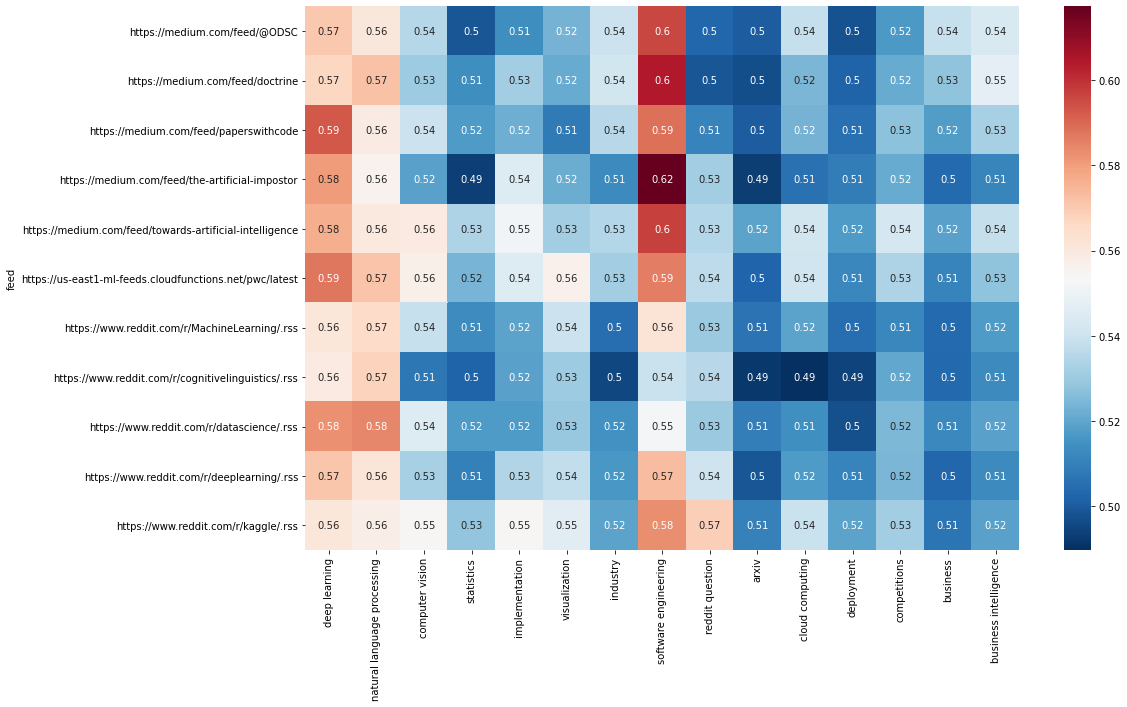

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

feed_topics_statistics_df = scores_df.groupby('feed').agg('mean')
plt.figure(figsize=(16, 10))
sns.heatmap(feed_topics_statistics_df, annot=True, cmap='RdBu_r')
